In [3]:
!pip install -U fastai

ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 1.0.1 which is incompatible.



  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19196 sha256=f99991c323620dd0a089ef276428b35e9f90d8a6f8d49cbff4dc722b4edcda69
  Stored in directory: c:\users\kwande\appdata\local\pip\cache\wheels\df\99\da\c34f202dc8fd1dffd35e0ecf1a7d7f8374ca05fbcbaf974b83
Successfully built nvidia-ml-py3


In [16]:
from fastai import *
from fastai.text import *
from pathlib import Path
import pandas as pd
import numpy as np
import re
import string

In [28]:
train = pd.read_csv('Train.csv')

In [20]:
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [21]:
import torch
print('Cuda' if torch.cuda.is_available() is True else 'CPU')
print('Pytrch ver:', torch.__version__)

CPU
Pytrch ver: 1.0.1


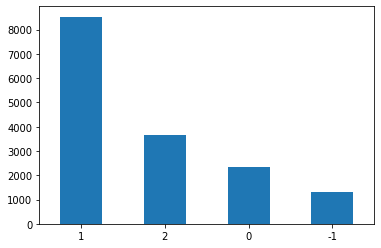

In [22]:
train['sentiment'].value_counts().plot.bar(rot = 0)

In [30]:
#cleaning functions

#create mention list
def m_fin(text):
    mentions = []
    men_f = re.compile(r'@([a-zA-Z0-9-z#_]+)')
    for word in text:
         mentions = men_f.findall(text)
    return mentions

#create hashtag list
def hash_finder(tweet):
    hashes = []
    finder = re.compile(r'#([a-zA-Z0-9-z#_]+)')
    for word in tweet:
        hashes = finder.findall(tweet)
    return hashes

#create url list
def url_fr(text):
    url = re.compile(r"([https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,}])")
    for link in text:
        found = url.findall(text)
    return found

#precleaning
def clean_text(text):
    text = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "", text)

    # remove numbers
    text_nonum = re.sub(r'\d+', '', text)
    # remove 
    #text_nomen = re.sub(r'(@[a-zA-Z0-9-z#_]+)','', text_nonum)
    text_nohash = re.sub(r'(#[a-zA-Z0-9-z#_]+)', '', text_nonum)
    # remove punctuations and convert characters to lower case
    text_nopunct = "".join([char.lower() for char in text_nohash if char not in string.punctuation]) 
    # substitute multiple whitespace with single whitespace
    # Also, removes leading and trailing whitespaces
    text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()
    return text_no_doublespace

#lemmetize
def lemm(word):
        result = wordnet.morphy(word)
        if result is None:
            return word
        else: return result
#remove stop words
def tokenizer_2(tokenized):
    tokenized = word_tokenize(tokenized)
    tokenized = [t for t in tokenized if (t not in  stop and t not in stop2 and len(t) > 1)]
    tokenized = [lemm(t) for t in tokenized]
    return tokenized

#tweet word length
def counter(text):
    # remove numbers
    count = len(text)
    return count

train['tags'] = train['message'].apply(hash_finder)
train['url'] = train['message'].apply(url_fr)
train['cleaned'] = train['message'].apply(clean_text)

In [55]:
saver = pd.DataFrame(data = (train[['sentiment', 'cleaned']]), copy = True)
saver.to_csv('saver.csv', header = False, index = False)

In [56]:
path = './'
data_lm = TextLMDataBunch.from_csv(path , 'saver.csv', min_freq=1)

In [57]:
data_lm.save()

In [59]:
# # Reload LM and clas data from file if doing so for large cases
#data_lm = TextLMDataBunch.load(path)
#data_clas = TextClasDataBunch.load(path, bs=32)
data_lm.show_batch()

idx,text
0,sofaking khoublake fahrenthold foxnews cnn weatherchannel gaughansurfing just keep repeating climate change is a l … xxbos rt frankieboyle lets look on the bright side maybe climate change will kill off humanity before a global fascist government can start tã¢â‚¬â ¦ xxbos rt arthur the great american disconnect with global warming xxbos world leaders duped by manipulated global warming data realdonaldtrump spot on with your gut feelings xxbos rt planetgreen
1,other climate change issues is an effective tool xxbos rt mishacollins good point realdonaldtrump is the candidate who might end global warming by bringing us nuclear winter do nt beã¢â‚¬â ¦ xxbos rt billnye just a little climate change what s a few billion here or there xxbos rt tveitdal china blames climate change for record sea levels xxbos call your senators tell them to block trump ’s cabinet of
2,yearsofliving c on natgeochannel xxbos rt glenont the huge weight of working on climate change is that once you know the science amp how little time we have to act u ca nt ever … xxbos the epa is planning a debate about climate change but bill nye says that debates already been settled xxbos climate change is real climate change is real climate change is real climate change is
3,warming researchers say xxbos rt gadsaad hey billnye you are off the hook its due to boredom not climate change we found the culprit xxbos rt greenpeacenz were the last generation that can stop climate change rise up end oil xxbos derds peterbaynham also he believes global warming is a myth that alone might wipe us all out xxbos new research points out that climate change will increase fire activity
4,the us or not h … xxbos rt sensanders we have a presidentelect who does nt believe in climate change millions of people are going to have to say mr tã¢â‚¬â ¦ xxbos epascottpruitt does nt think co drives climate change lets send him a copy of global warming for dummies xxbos rt altnatparkser trump knows climate change is real he just does nt care for deniers ignoring these worries


In [63]:
learner = language_model_learner(data_lm, arch = AWD_LSTM, pretrained = True, drop_mult =0.1)

In [64]:
list(learner.model.children())

[AWD_LSTM(
   (encoder): Embedding(20352, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(20352, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1152, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1152, 1152, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1152, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ),
 LinearDecoder(
   (decoder): Linear(in_features=400, out_features=20352, bias=True)
   (output_dp): RNNDropout()
 )]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


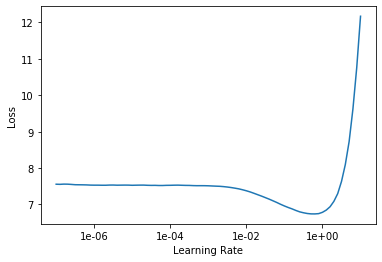

In [65]:
learner.lr_find(start_lr=1e-8,end_lr=1e2)
learner.recorder.plot()

In [67]:
learner = language_model_learner(data_lm, arch = AWD_LSTM, pretrained = True, 
                               drop_mult=0.5)
learner.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,7.170508,6.305771,0.159997,04:34


In [68]:
learner.unfreeze()
learner.fit_one_cycle(cyc_len=20, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.005454,5.260225,0.241151,09:45
1,5.521070,4.923249,0.298661,09:50
2,5.149958,4.711720,0.325159,09:49
3,4.805647,4.442574,0.353237,09:47
4,4.459412,4.276330,0.375207,09:45
5,4.164099,4.196540,0.387293,09:44
6,3.818976,4.173489,0.398214,09:52
7,3.486273,4.183774,0.403013,09:54
8,3.191787,4.177151,0.409598,09:51
9,2.916767,4.227705,0.409040,10:27


In [69]:
learner.save_encoder('ft_enc')
